In [9]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Check TensorFlow version to ensure compatibility
print("TensorFlow version:", tf.__version__)

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)


TensorFlow version: 2.18.0


In [10]:
# Load the MNIST dataset (only training images, labels are not required for GANs)
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalize the images to the range [0, 1]
train_images = train_images.astype("float32") / 255.0

# Reshape the images to include the channel dimension (28x28x1 for grayscale images)
train_images = np.expand_dims(train_images, axis=-1)

# Print the dataset shape for verification
print("Shape of training images:", train_images.shape)


Shape of training images: (60000, 28, 28, 1)


In [11]:
# Define buffer size for shuffling and batch size for mini-batch gradient descent
BUFFER_SIZE = 60000  # Number of training images in MNIST
BATCH_SIZE = 256     # Batch size for training

# Create a TensorFlow dataset, shuffle it, and batch it
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

# Confirm dataset batching by inspecting the shape of one batch
for batch in train_dataset.take(1):
    print("Shape of a batch:", batch.shape)


Shape of a batch: (256, 28, 28, 1)


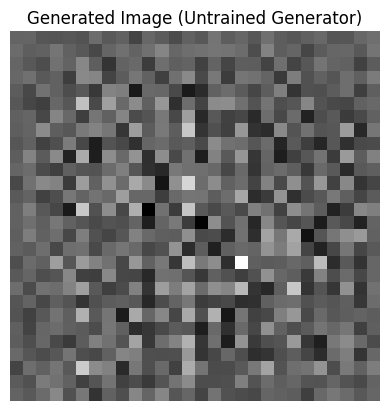

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [13]:
def build_generator():
    model = tf.keras.Sequential([
        # Dense layer to project noise into a 7x7x256 tensor
        layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((7, 7, 256)),  # Reshape to 7x7x256

        # Transposed convolution layers to upsample the image
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # Final layer to generate an image of shape 28x28x1
        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="tanh")
    ])
    return model

# Create the generator model
generator = build_generator()

# Generate a random noise vector
noise = tf.random.normal([1, 100])

# Generate an image using the untrained generator
generated_image = generator(noise, training=False)

# Visualize the generated image
plt.imshow(generated_image[0, :, :, 0], cmap="gray")
plt.title("Generated Image (Untrained Generator)")
plt.axis("off")
plt.show()

# Print the generator's architecture
generator.summary()


In [14]:
def build_discriminator():
    model = tf.keras.Sequential([
        # Convolutional layers to extract features from images
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=(28, 28, 1)),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        # Fully connected layer to output a single value (real or fake)
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid")
    ])
    return model

# Create the discriminator model
discriminator = build_discriminator()

# Test the discriminator on the generated image
decision = discriminator(generated_image, training=False)

# Print the discriminator's decision
print("Discriminator's decision on generated image:", decision.numpy())

# Print the discriminator's architecture
discriminator.summary()


Discriminator's decision on generated image: [[0.500032]]


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Define binary cross-entropy loss for both models
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Discriminator loss: Compare real vs. fake images
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)  # Real images labeled as 1
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # Fake images labeled as 0
    return real_loss + fake_loss

# Generator loss: Ensure fake images look real
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)  # Fake images labeled as 1

# Define optimizers for both models
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

print("Loss functions and optimizers defined successfully!")


Loss functions and optimizers defined successfully!


Training started...
Epoch 1/100


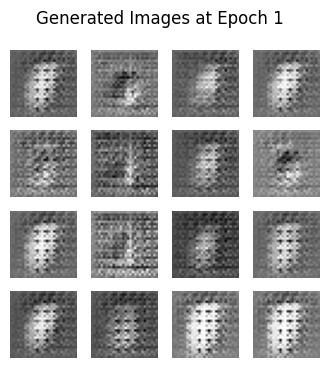

Generator Loss: 0.8616, Discriminator Loss: 1.2023
Epoch 2/100


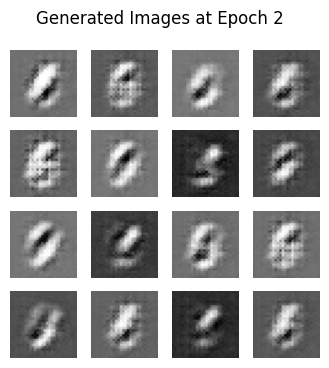

Generator Loss: 0.6391, Discriminator Loss: 1.4050
Epoch 3/100


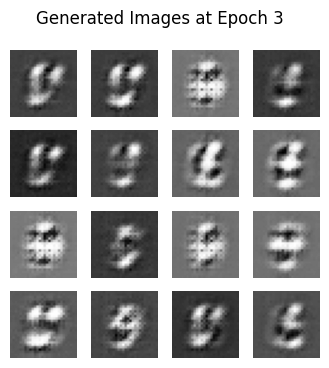

Generator Loss: 0.8856, Discriminator Loss: 1.0575
Epoch 4/100


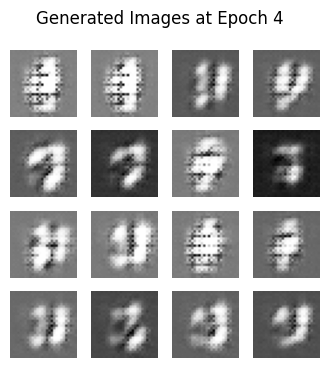

Generator Loss: 1.0634, Discriminator Loss: 1.0201
Epoch 5/100


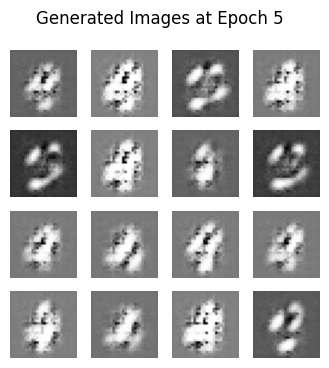

Generator Loss: 0.9681, Discriminator Loss: 1.0272
Epoch 6/100


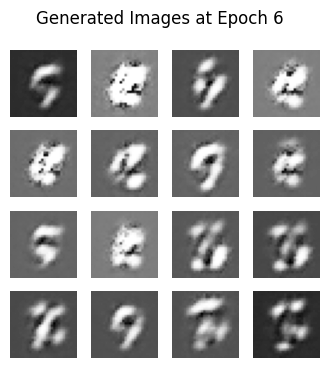

Generator Loss: 1.3312, Discriminator Loss: 0.7830
Epoch 7/100


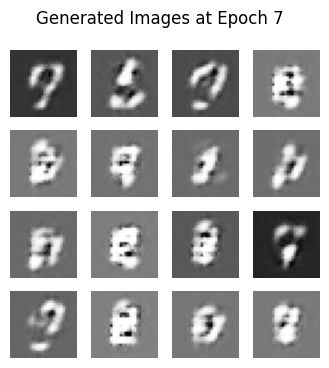

Generator Loss: 1.4558, Discriminator Loss: 0.6899
Epoch 8/100


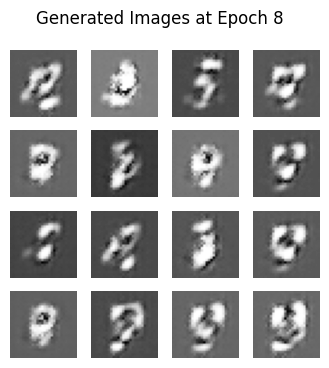

Generator Loss: 1.4483, Discriminator Loss: 0.6730
Epoch 9/100


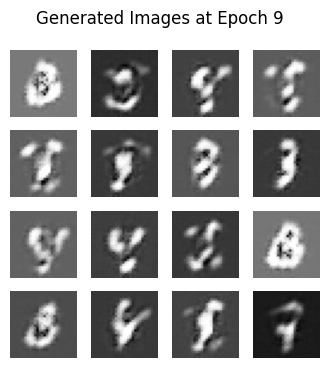

Generator Loss: 1.8427, Discriminator Loss: 0.5924
Epoch 10/100


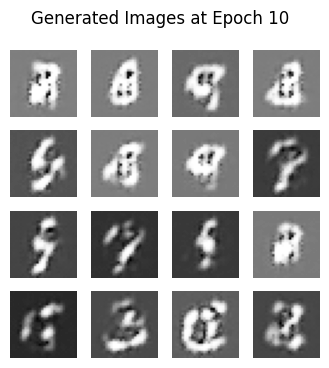

Generator Loss: 1.7211, Discriminator Loss: 0.6965
Epoch 11/100


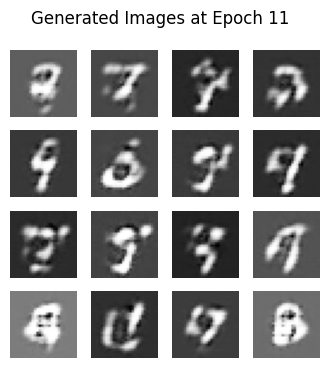

Generator Loss: 2.2400, Discriminator Loss: 0.5978
Epoch 12/100


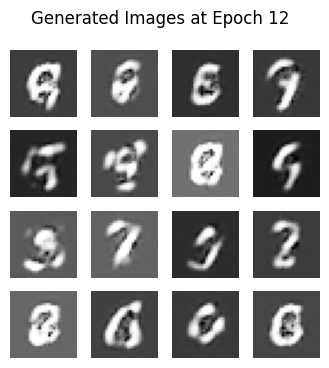

Generator Loss: 2.1219, Discriminator Loss: 0.6345
Epoch 13/100


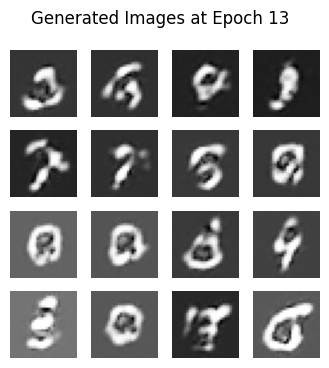

Generator Loss: 2.2879, Discriminator Loss: 0.5989
Epoch 14/100


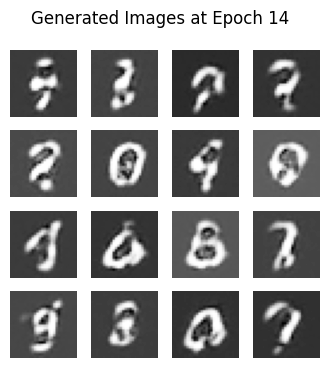

Generator Loss: 2.2110, Discriminator Loss: 0.5358
Epoch 15/100


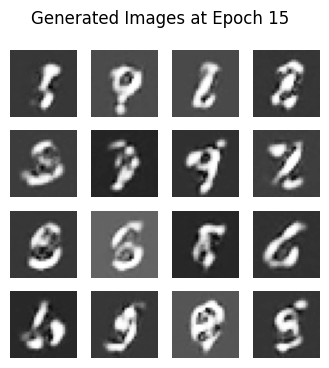

Generator Loss: 2.2540, Discriminator Loss: 0.5415
Epoch 16/100


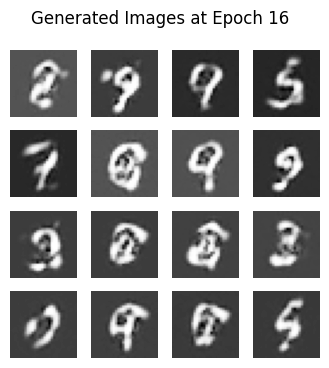

Generator Loss: 2.2774, Discriminator Loss: 0.4514
Epoch 17/100


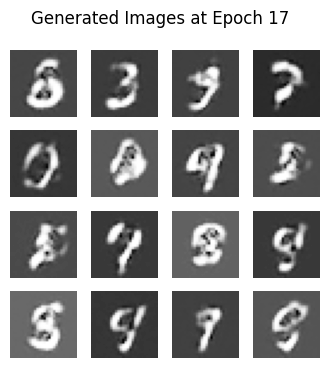

Generator Loss: 2.3838, Discriminator Loss: 0.5046
Epoch 18/100


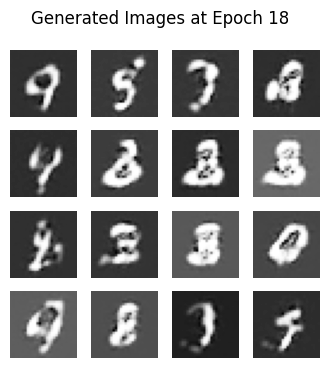

Generator Loss: 2.4252, Discriminator Loss: 0.4592
Epoch 19/100


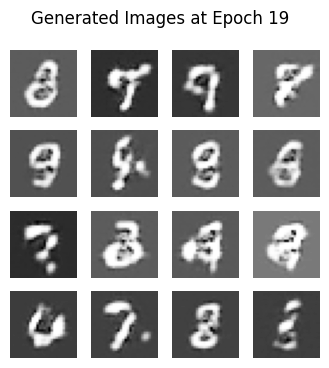

Generator Loss: 2.3225, Discriminator Loss: 0.5040
Epoch 20/100


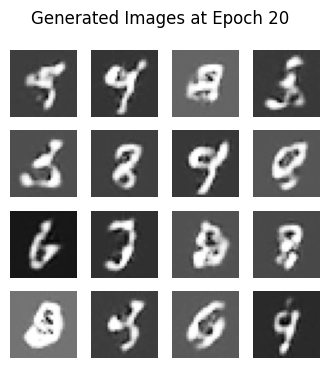

Generator Loss: 2.2113, Discriminator Loss: 0.5102
Epoch 21/100


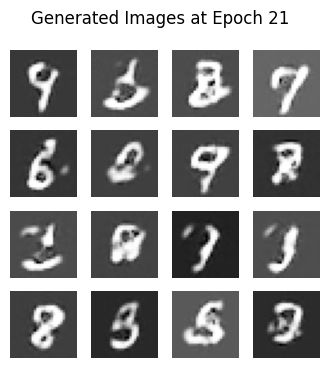

Generator Loss: 2.0568, Discriminator Loss: 0.5685
Epoch 22/100


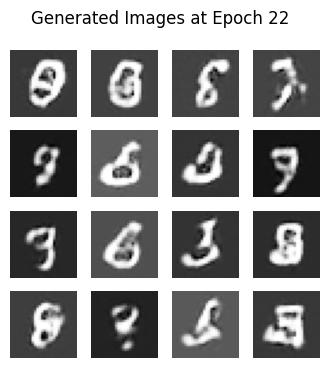

Generator Loss: 2.5070, Discriminator Loss: 0.6438
Epoch 23/100


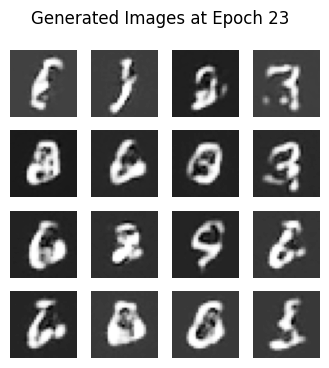

Generator Loss: 2.0899, Discriminator Loss: 0.6102
Epoch 24/100


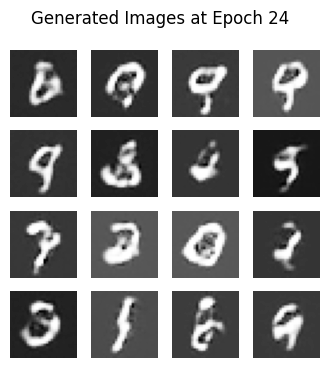

Generator Loss: 2.2716, Discriminator Loss: 0.6170
Epoch 25/100


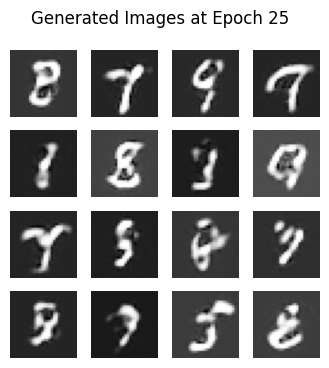

Generator Loss: 2.0840, Discriminator Loss: 0.6338
Epoch 26/100


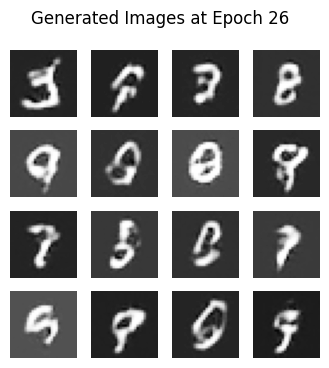

Generator Loss: 2.2169, Discriminator Loss: 0.6729
Epoch 27/100


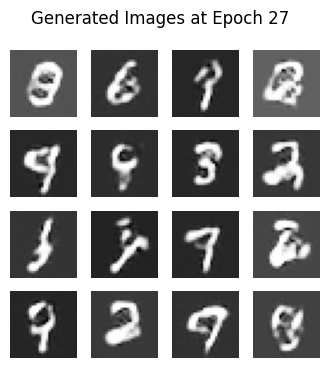

Generator Loss: 1.9473, Discriminator Loss: 0.6153
Epoch 28/100


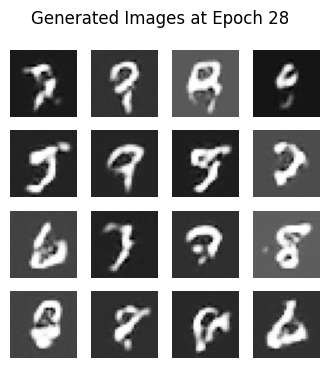

Generator Loss: 2.1634, Discriminator Loss: 0.5377
Epoch 29/100


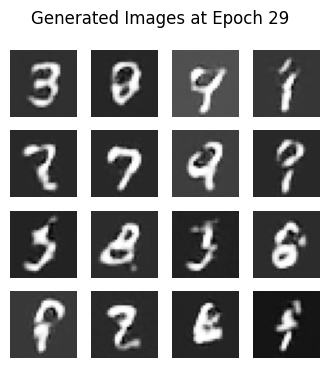

Generator Loss: 2.2109, Discriminator Loss: 0.6243
Epoch 30/100


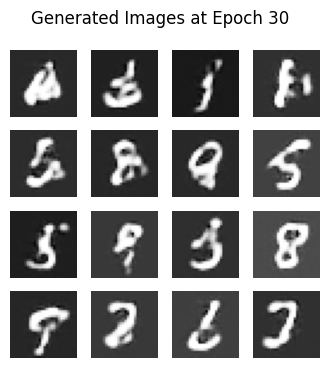

Generator Loss: 2.0818, Discriminator Loss: 0.5352
Epoch 31/100


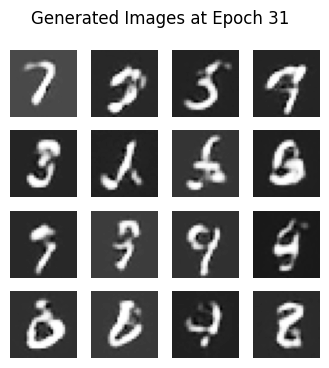

Generator Loss: 2.0945, Discriminator Loss: 0.5594
Epoch 32/100


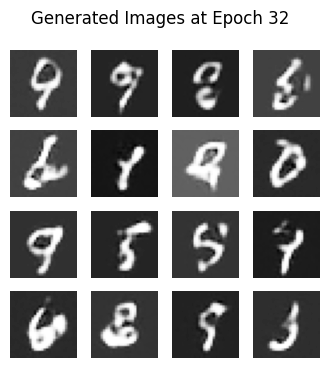

Generator Loss: 2.0368, Discriminator Loss: 0.7103
Epoch 33/100


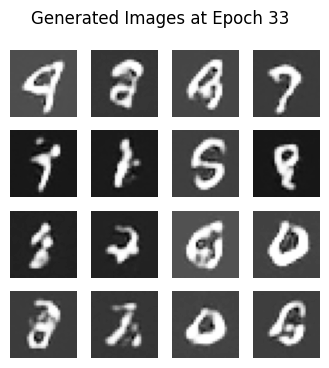

Generator Loss: 2.0766, Discriminator Loss: 0.5864
Epoch 34/100


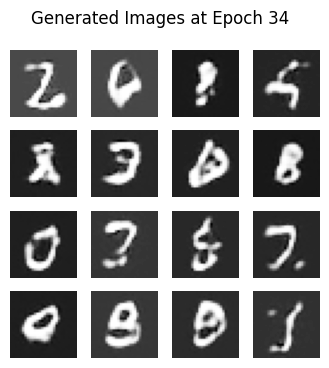

Generator Loss: 1.9876, Discriminator Loss: 0.5833
Epoch 35/100


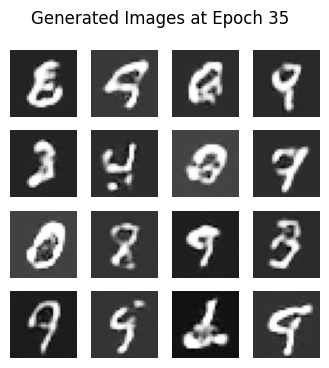

Generator Loss: 2.1713, Discriminator Loss: 0.5479
Epoch 36/100


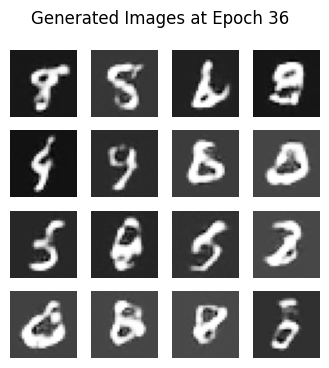

Generator Loss: 1.9561, Discriminator Loss: 0.6580
Epoch 37/100


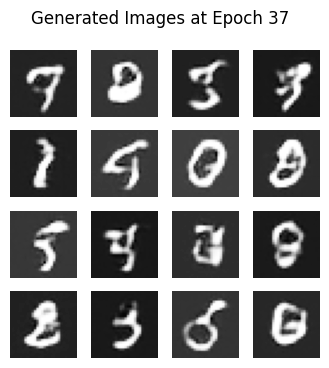

Generator Loss: 2.1814, Discriminator Loss: 0.6012
Epoch 38/100


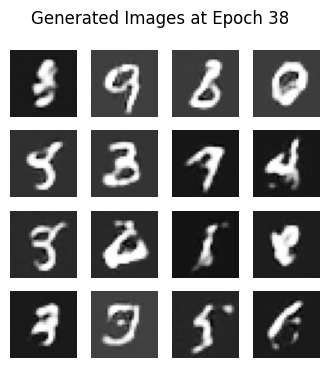

Generator Loss: 2.1448, Discriminator Loss: 0.6459
Epoch 39/100


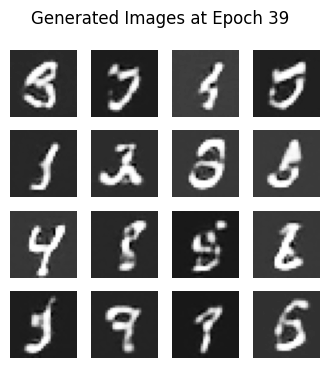

Generator Loss: 2.1840, Discriminator Loss: 0.6562
Epoch 40/100


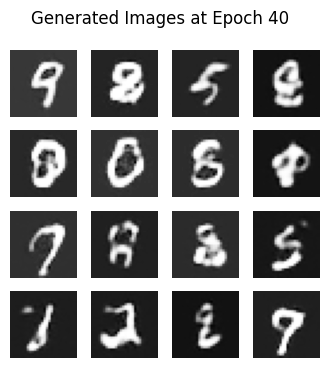

Generator Loss: 2.2778, Discriminator Loss: 0.5088
Epoch 41/100


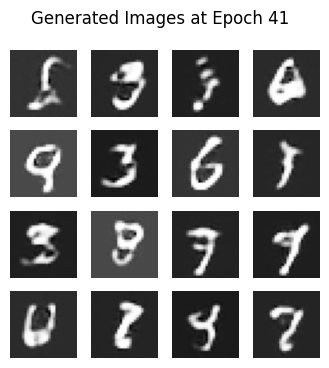

Generator Loss: 2.0906, Discriminator Loss: 0.6422
Epoch 42/100


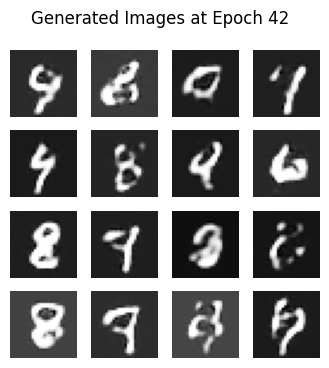

Generator Loss: 2.1691, Discriminator Loss: 0.7056
Epoch 43/100


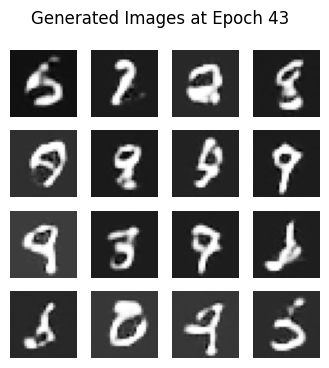

Generator Loss: 1.9353, Discriminator Loss: 0.6552
Epoch 44/100


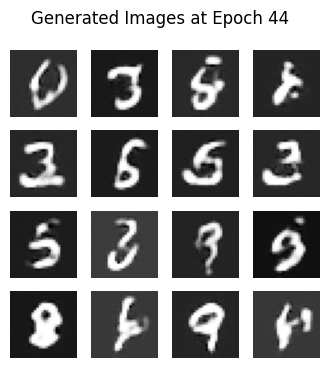

Generator Loss: 2.1146, Discriminator Loss: 0.5245
Epoch 45/100


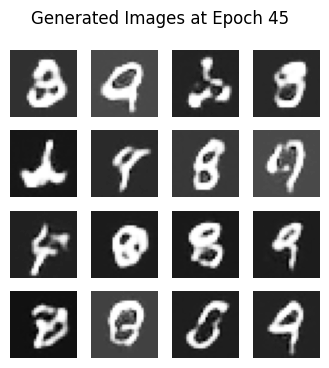

Generator Loss: 2.1429, Discriminator Loss: 0.5419
Epoch 46/100


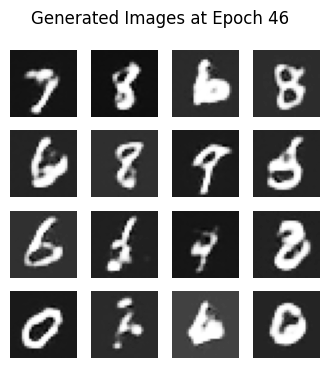

Generator Loss: 1.9764, Discriminator Loss: 0.5816
Epoch 47/100


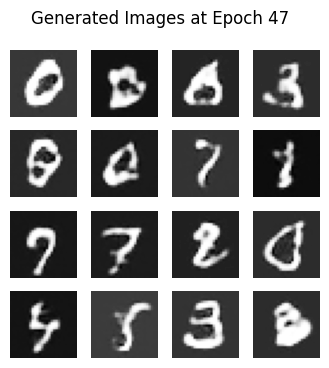

Generator Loss: 2.0665, Discriminator Loss: 0.5716
Epoch 48/100


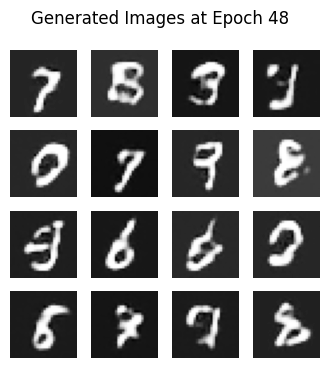

Generator Loss: 2.1355, Discriminator Loss: 0.5800
Epoch 49/100


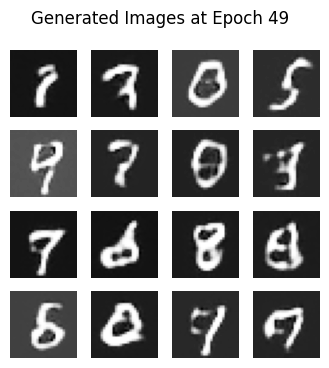

Generator Loss: 2.3566, Discriminator Loss: 0.5813
Epoch 50/100


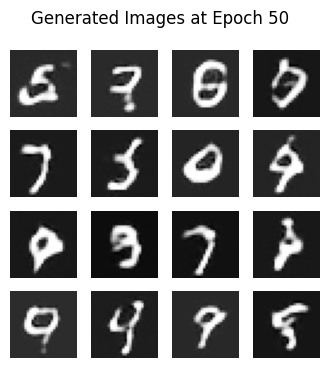

Generator Loss: 2.1585, Discriminator Loss: 0.5839
Epoch 51/100


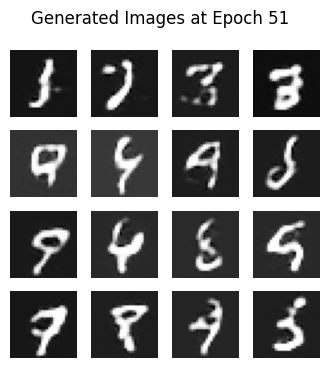

Generator Loss: 2.3896, Discriminator Loss: 0.5559
Epoch 52/100


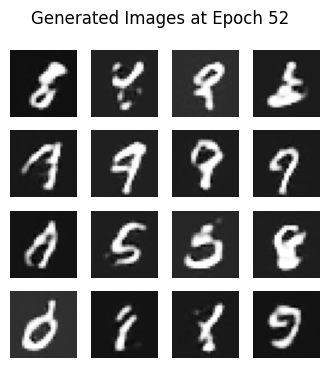

Generator Loss: 2.4878, Discriminator Loss: 0.6120
Epoch 53/100


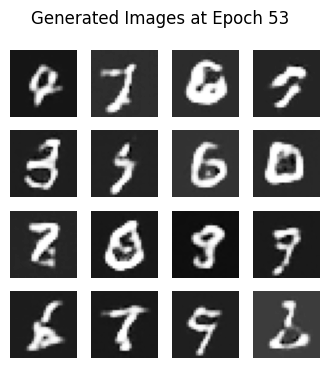

Generator Loss: 2.3100, Discriminator Loss: 0.5909
Epoch 54/100


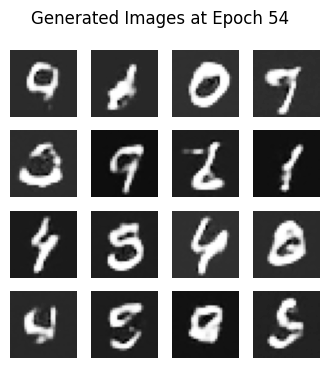

Generator Loss: 2.1261, Discriminator Loss: 0.5994
Epoch 55/100


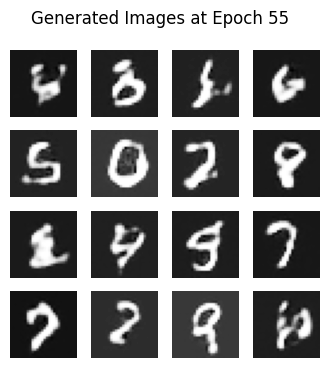

Generator Loss: 2.1582, Discriminator Loss: 0.4425
Epoch 56/100


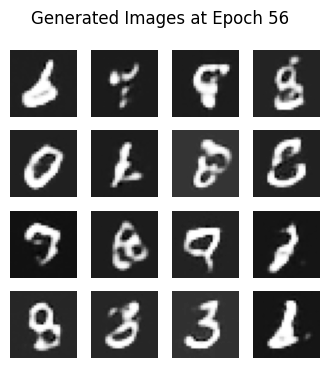

Generator Loss: 2.2512, Discriminator Loss: 0.5562
Epoch 57/100


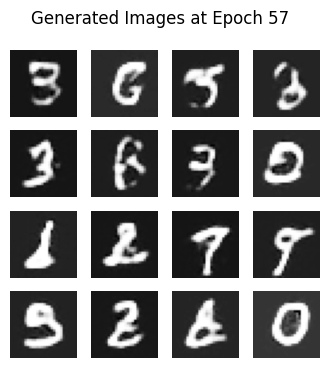

Generator Loss: 2.2964, Discriminator Loss: 0.5324
Epoch 58/100


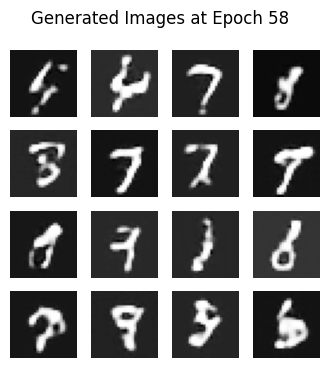

Generator Loss: 2.4793, Discriminator Loss: 0.5346
Epoch 59/100


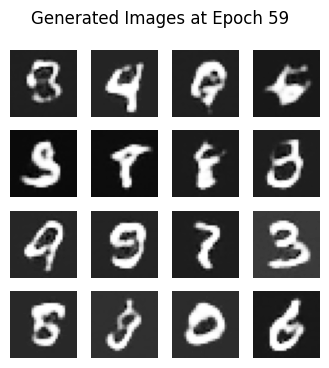

Generator Loss: 2.0363, Discriminator Loss: 0.5179
Epoch 60/100


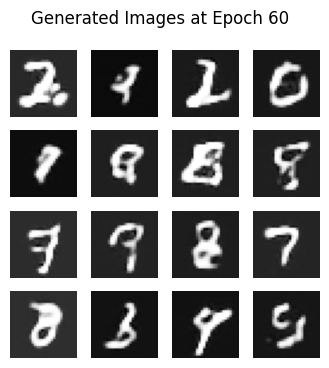

Generator Loss: 2.2235, Discriminator Loss: 0.4792
Epoch 61/100


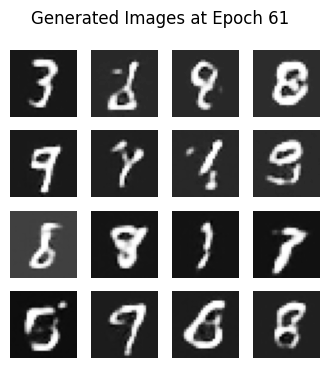

Generator Loss: 2.3596, Discriminator Loss: 0.5453
Epoch 62/100


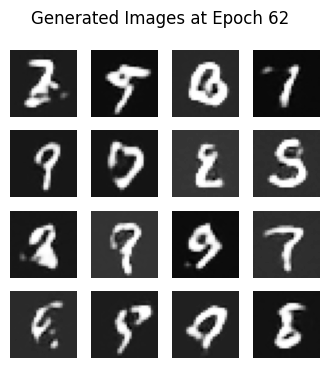

Generator Loss: 2.5220, Discriminator Loss: 0.5134
Epoch 63/100


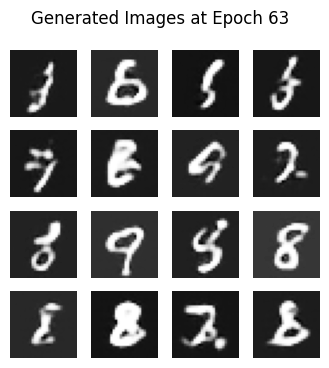

Generator Loss: 2.4975, Discriminator Loss: 0.4602
Epoch 64/100


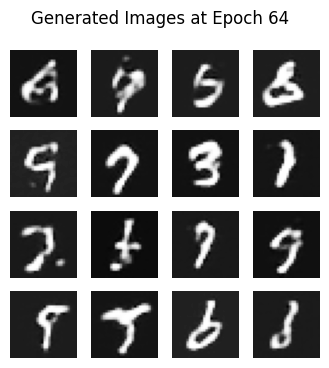

Generator Loss: 2.3072, Discriminator Loss: 0.4861
Epoch 65/100


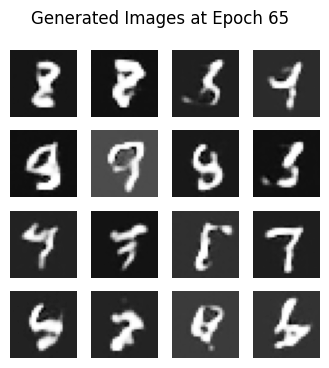

Generator Loss: 2.2809, Discriminator Loss: 0.4297
Epoch 66/100


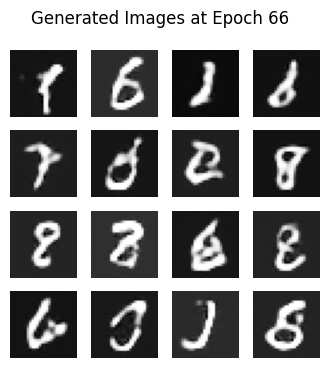

Generator Loss: 2.3560, Discriminator Loss: 0.4617
Epoch 67/100


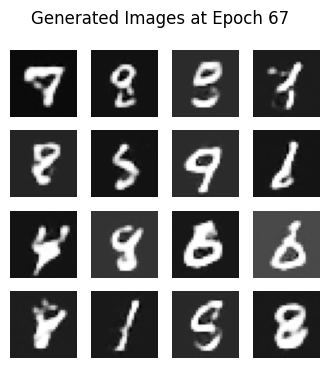

Generator Loss: 2.3278, Discriminator Loss: 0.4808
Epoch 68/100


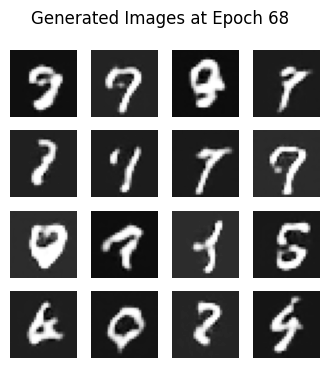

Generator Loss: 2.5784, Discriminator Loss: 0.4726
Epoch 69/100


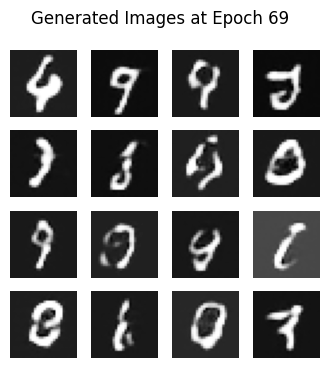

Generator Loss: 2.5909, Discriminator Loss: 0.4271
Epoch 70/100


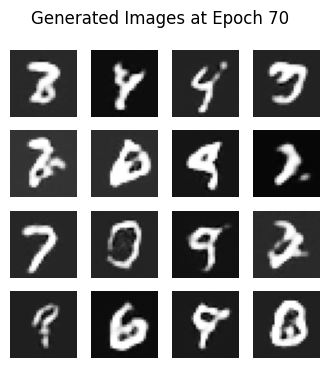

Generator Loss: 2.4978, Discriminator Loss: 0.5533
Epoch 71/100


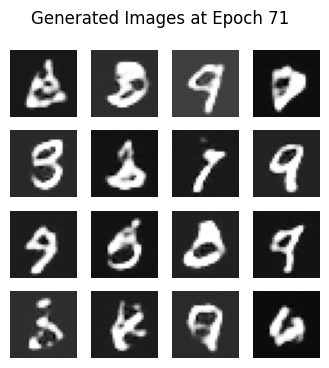

Generator Loss: 2.4830, Discriminator Loss: 0.4814
Epoch 72/100


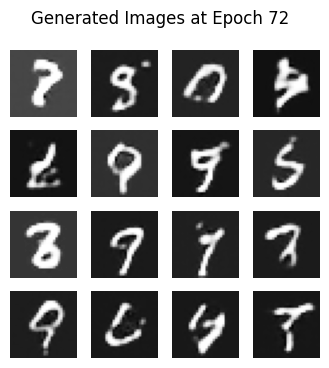

Generator Loss: 2.6348, Discriminator Loss: 0.4176
Epoch 73/100


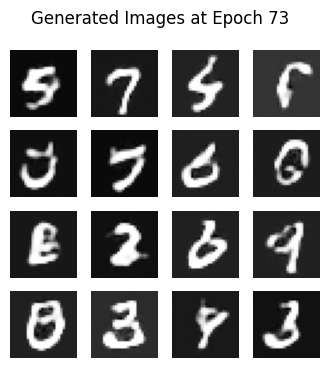

Generator Loss: 2.6375, Discriminator Loss: 0.4093
Epoch 74/100


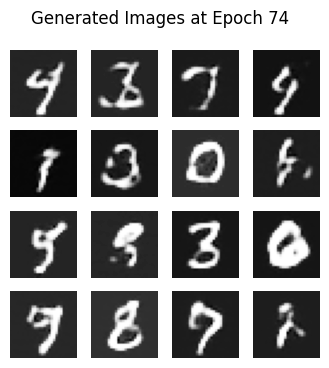

Generator Loss: 2.2534, Discriminator Loss: 0.4390
Epoch 75/100


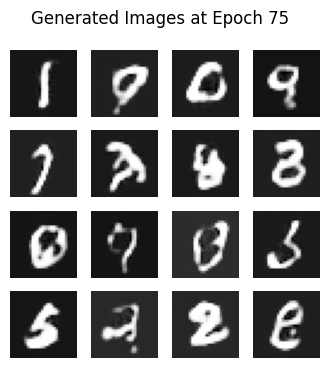

Generator Loss: 2.1759, Discriminator Loss: 0.4095
Epoch 76/100


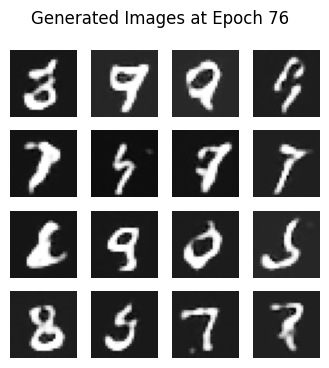

Generator Loss: 2.3989, Discriminator Loss: 0.4453
Epoch 77/100


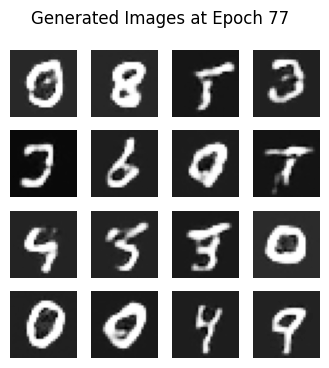

Generator Loss: 2.5401, Discriminator Loss: 0.5117
Epoch 78/100


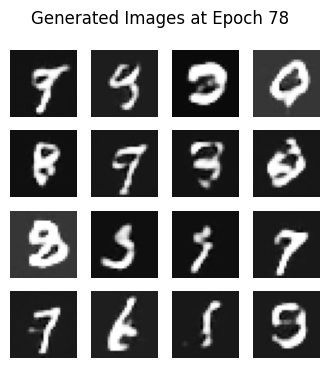

Generator Loss: 2.3639, Discriminator Loss: 0.3835
Epoch 79/100


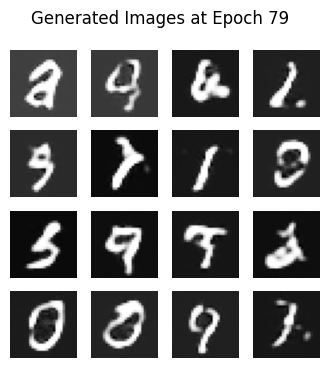

Generator Loss: 2.7541, Discriminator Loss: 0.4379
Epoch 80/100


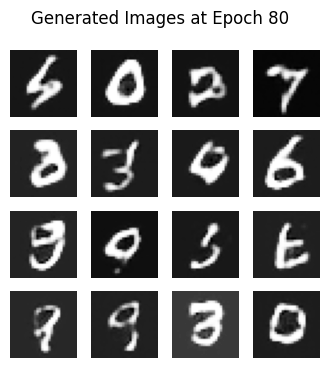

Generator Loss: 2.9758, Discriminator Loss: 0.3487
Epoch 81/100


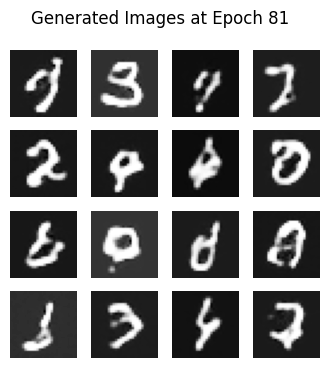

Generator Loss: 2.4571, Discriminator Loss: 0.5119
Epoch 82/100


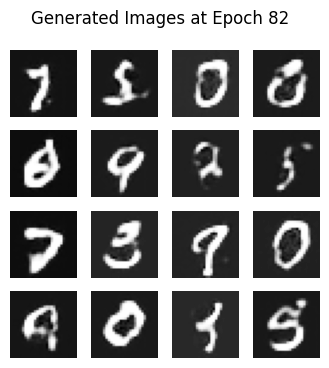

Generator Loss: 2.7548, Discriminator Loss: 0.4401
Epoch 83/100


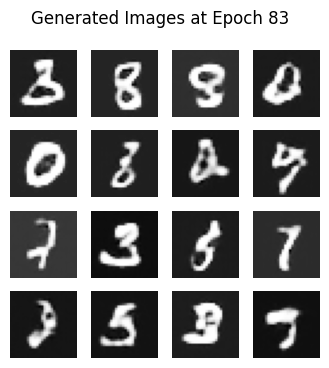

Generator Loss: 2.6505, Discriminator Loss: 0.4074
Epoch 84/100


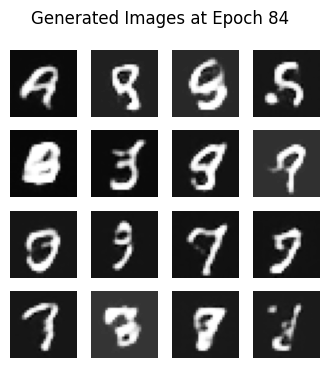

Generator Loss: 2.5451, Discriminator Loss: 0.4682
Epoch 85/100


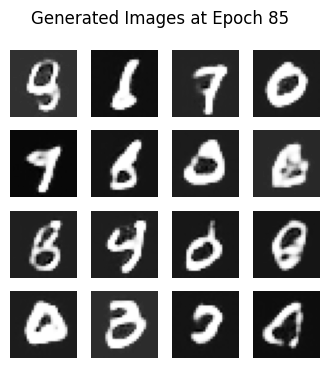

Generator Loss: 2.4782, Discriminator Loss: 0.4454
Epoch 86/100


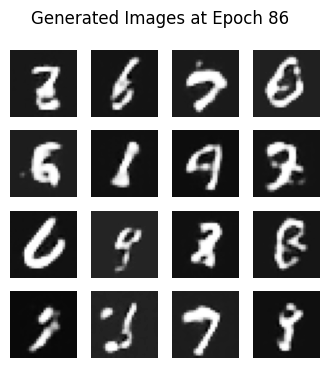

Generator Loss: 2.6140, Discriminator Loss: 0.3537
Epoch 87/100


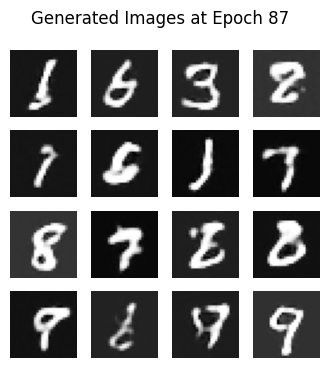

Generator Loss: 2.5619, Discriminator Loss: 0.4677
Epoch 88/100


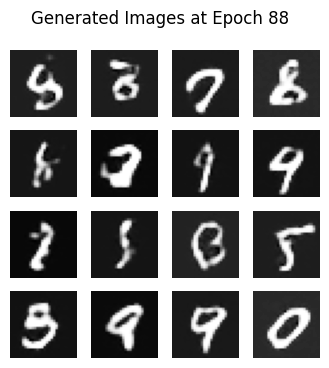

Generator Loss: 2.6338, Discriminator Loss: 0.3727
Epoch 89/100


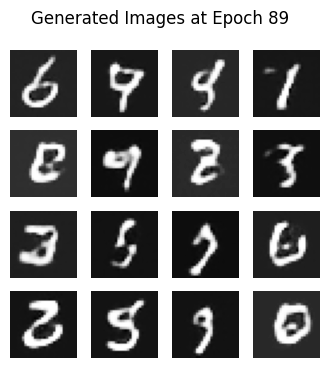

Generator Loss: 2.7458, Discriminator Loss: 0.4379
Epoch 90/100


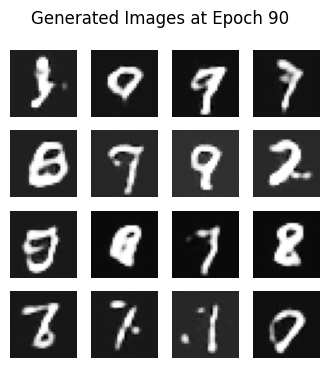

Generator Loss: 2.5671, Discriminator Loss: 0.4421
Epoch 91/100


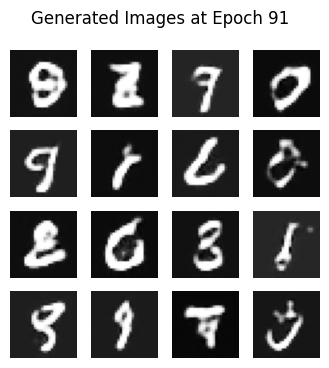

Generator Loss: 2.7319, Discriminator Loss: 0.3113
Epoch 92/100


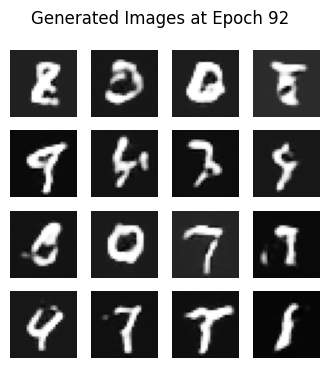

Generator Loss: 2.8812, Discriminator Loss: 0.4210
Epoch 93/100


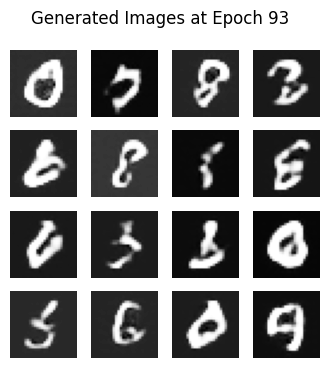

Generator Loss: 2.8329, Discriminator Loss: 0.2771
Epoch 94/100


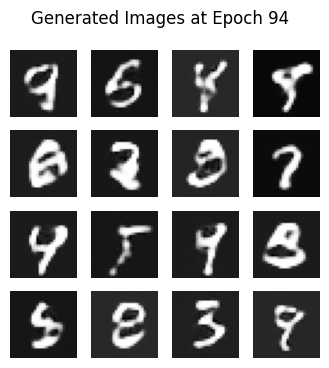

Generator Loss: 2.3960, Discriminator Loss: 0.4607
Epoch 95/100


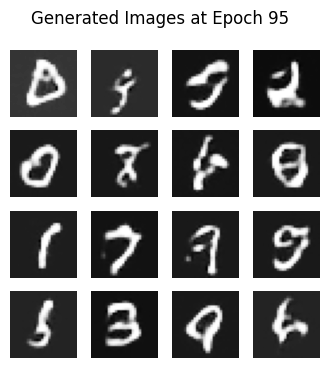

Generator Loss: 3.2028, Discriminator Loss: 0.4450
Epoch 96/100


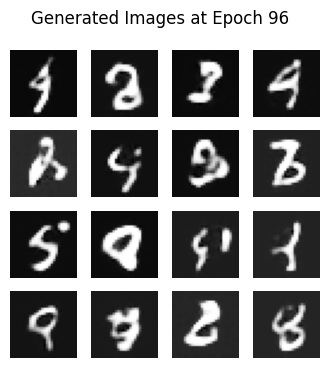

Generator Loss: 2.5087, Discriminator Loss: 0.3988
Epoch 97/100


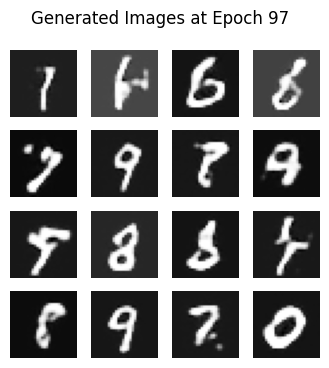

Generator Loss: 2.7558, Discriminator Loss: 0.3367
Epoch 98/100


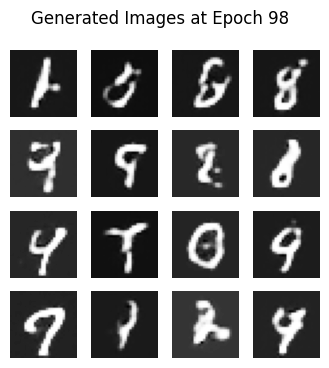

Generator Loss: 2.8942, Discriminator Loss: 0.3528
Epoch 99/100


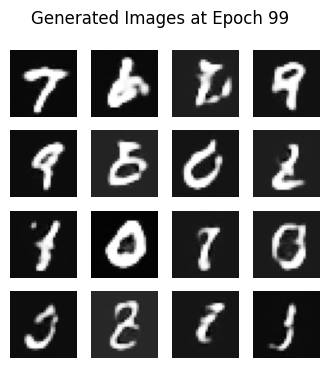

Generator Loss: 3.0250, Discriminator Loss: 0.4400
Epoch 100/100


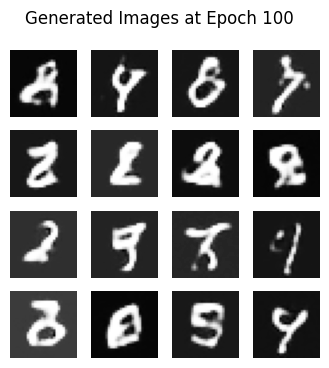

Generator Loss: 2.9687, Discriminator Loss: 0.4795
Training completed!


In [17]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])  # Generate random noise

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images
        generated_images = generator(noise, training=True)

        # Get discriminator outputs
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Compute losses
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Compute and apply gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

        # Generate and visualize images at the end of each epoch
        noise = tf.random.normal([16, 100])
        generated_images = generator(noise, training=False)

        plt.figure(figsize=(4, 4))
        for i in range(16):
            plt.subplot(4, 4, i + 1)
            plt.imshow(generated_images[i, :, :, 0], cmap="gray")
            plt.axis("off")
        plt.suptitle(f"Generated Images at Epoch {epoch + 1}")
        plt.show()

        print(f"Generator Loss: {gen_loss.numpy():.4f}, Discriminator Loss: {disc_loss.numpy():.4f}")

# Start training
EPOCHS = 100
print("Training started...")
train(train_dataset, EPOCHS)
print("Training completed!")


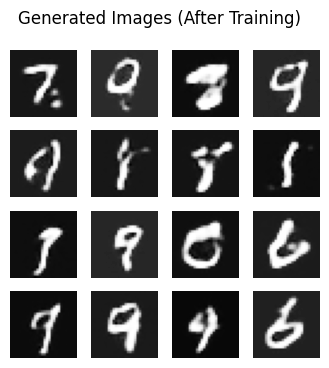

In [22]:
# Generate and visualize more images
noise = tf.random.normal([16, 100])  # Generate 16 random noise vectors
generated_images = generator(noise, training=False)

# Plot the generated images
plt.figure(figsize=(4, 4))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(generated_images[i, :, :, 0], cmap="gray")
    plt.axis("off")
plt.suptitle("Generated Images (After Training)")
plt.show()


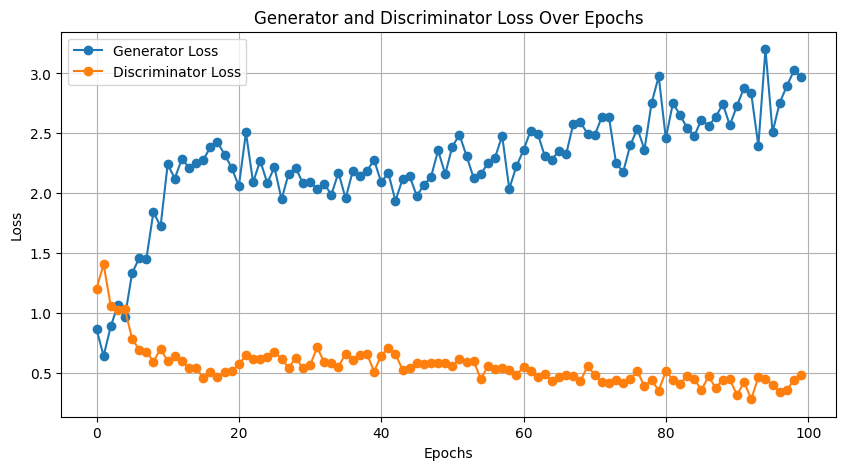

In [1]:
import re
import matplotlib.pyplot as plt

# Extracted text from the file containing the logs
log_data = """
Epoch 1/100
Generator Loss: 0.8616, Discriminator Loss: 1.2023
Epoch 2/100
Generator Loss: 0.6391, Discriminator Loss: 1.4050
Epoch 3/100
Generator Loss: 0.8856, Discriminator Loss: 1.0575
Epoch 4/100
Generator Loss: 1.0634, Discriminator Loss: 1.0201
Epoch 5/100
Generator Loss: 0.9681, Discriminator Loss: 1.0272
Epoch 6/100
Generator Loss: 1.3312, Discriminator Loss: 0.7830
Epoch 7/100
Generator Loss: 1.4558, Discriminator Loss: 0.6899
Epoch 8/100
Generator Loss: 1.4483, Discriminator Loss: 0.6730
Epoch 9/100
Generator Loss: 1.8427, Discriminator Loss: 0.5924
Epoch 10/100
Generator Loss: 1.7211, Discriminator Loss: 0.6965
Epoch 11/100
Generator Loss: 2.2400, Discriminator Loss: 0.5978
Epoch 12/100
Generator Loss: 2.1219, Discriminator Loss: 0.6345
Epoch 13/100
Generator Loss: 2.2879, Discriminator Loss: 0.5989
Epoch 14/100
Generator Loss: 2.2110, Discriminator Loss: 0.5358
Epoch 15/100
Generator Loss: 2.2540, Discriminator Loss: 0.5415
Epoch 16/100
Generator Loss: 2.2774, Discriminator Loss: 0.4514
Epoch 17/100
Generator Loss: 2.3838, Discriminator Loss: 0.5046
Epoch 18/100
Generator Loss: 2.4252, Discriminator Loss: 0.4592
Epoch 19/100
Generator Loss: 2.3225, Discriminator Loss: 0.5040
Epoch 20/100
Generator Loss: 2.2113, Discriminator Loss: 0.5102
Epoch 21/100
Generator Loss: 2.0568, Discriminator Loss: 0.5685
Epoch 22/100
Generator Loss: 2.5070, Discriminator Loss: 0.6438
Epoch 23/100
Generator Loss: 2.0899, Discriminator Loss: 0.6102
Epoch 24/100
Generator Loss: 2.2716, Discriminator Loss: 0.6170
Epoch 25/100
Generator Loss: 2.0840, Discriminator Loss: 0.6338
Epoch 26/100
Generator Loss: 2.2169, Discriminator Loss: 0.6729
Epoch 27/100
Generator Loss: 1.9473, Discriminator Loss: 0.6153
Epoch 28/100
Generator Loss: 2.1634, Discriminator Loss: 0.5377
Epoch 29/100
Generator Loss: 2.2109, Discriminator Loss: 0.6243
Epoch 30/100
Generator Loss: 2.0818, Discriminator Loss: 0.5352
Epoch 31/100
Generator Loss: 2.0945, Discriminator Loss: 0.5594
Epoch 32/100
Generator Loss: 2.0368, Discriminator Loss: 0.7103
Epoch 33/100
Generator Loss: 2.0766, Discriminator Loss: 0.5864
Epoch 34/100
Generator Loss: 1.9876, Discriminator Loss: 0.5833
Epoch 35/100
Generator Loss: 2.1713, Discriminator Loss: 0.5479
Epoch 36/100
Generator Loss: 1.9561, Discriminator Loss: 0.6580
Epoch 37/100
Generator Loss: 2.1814, Discriminator Loss: 0.6012
Epoch 38/100
Generator Loss: 2.1448, Discriminator Loss: 0.6459
Epoch 39/100
Generator Loss: 2.1840, Discriminator Loss: 0.6562
Epoch 40/100
Generator Loss: 2.2778, Discriminator Loss: 0.5088
Epoch 41/100
Generator Loss: 2.0906, Discriminator Loss: 0.6422
Epoch 42/100
Generator Loss: 2.1691, Discriminator Loss: 0.7056
Epoch 43/100
Generator Loss: 1.9353, Discriminator Loss: 0.6552
Epoch 44/100
Generator Loss: 2.1146, Discriminator Loss: 0.5245
Epoch 45/100
Generator Loss: 2.1429, Discriminator Loss: 0.5419
Epoch 46/100
Generator Loss: 1.9764, Discriminator Loss: 0.5816
Epoch 47/100
Generator Loss: 2.0665, Discriminator Loss: 0.5716
Epoch 48/100
Generator Loss: 2.1355, Discriminator Loss: 0.5800
Epoch 49/100
Generator Loss: 2.3566, Discriminator Loss: 0.5813
Epoch 50/100
Generator Loss: 2.1585, Discriminator Loss: 0.5839
Epoch 51/100
Generator Loss: 2.3896, Discriminator Loss: 0.5559
Epoch 52/100
Generator Loss: 2.4878, Discriminator Loss: 0.6120
Epoch 53/100
Generator Loss: 2.3100, Discriminator Loss: 0.5909
Epoch 54/100
Generator Loss: 2.1261, Discriminator Loss: 0.5994
Epoch 55/100
Generator Loss: 2.1582, Discriminator Loss: 0.4425
Epoch 56/100
Generator Loss: 2.2512, Discriminator Loss: 0.5562
Epoch 57/100
Generator Loss: 2.2964, Discriminator Loss: 0.5324
Epoch 58/100
Generator Loss: 2.4793, Discriminator Loss: 0.5346
Epoch 59/100
Generator Loss: 2.0363, Discriminator Loss: 0.5179
Epoch 60/100
Generator Loss: 2.2235, Discriminator Loss: 0.4792
Epoch 61/100
Generator Loss: 2.3596, Discriminator Loss: 0.5453
Epoch 62/100
Generator Loss: 2.5220, Discriminator Loss: 0.5134
Epoch 63/100
Generator Loss: 2.4975, Discriminator Loss: 0.4602
Epoch 64/100
Generator Loss: 2.3072, Discriminator Loss: 0.4861
Epoch 65/100
Generator Loss: 2.2809, Discriminator Loss: 0.4297
Epoch 66/100
Generator Loss: 2.3560, Discriminator Loss: 0.4617
Epoch 67/100
Generator Loss: 2.3278, Discriminator Loss: 0.4808
Epoch 68/100
Generator Loss: 2.5784, Discriminator Loss: 0.4726
Epoch 69/100
Generator Loss: 2.5909, Discriminator Loss: 0.4271
Epoch 70/100
Generator Loss: 2.4978, Discriminator Loss: 0.5533
Epoch 71/100
Generator Loss: 2.4830, Discriminator Loss: 0.4814
Epoch 72/100
Generator Loss: 2.6348, Discriminator Loss: 0.4176
Epoch 73/100
Generator Loss: 2.6375, Discriminator Loss: 0.4093
Epoch 74/100
Generator Loss: 2.2534, Discriminator Loss: 0.4390
Epoch 75/100
Generator Loss: 2.1759, Discriminator Loss: 0.4095
Epoch 76/100
Generator Loss: 2.3989, Discriminator Loss: 0.4453
Epoch 77/100
Generator Loss: 2.5401, Discriminator Loss: 0.5117
Epoch 78/100
Generator Loss: 2.3639, Discriminator Loss: 0.3835
Epoch 79/100
Generator Loss: 2.7541, Discriminator Loss: 0.4379
Epoch 80/100
Generator Loss: 2.9758, Discriminator Loss: 0.3487
Epoch 81/100
Generator Loss: 2.4571, Discriminator Loss: 0.5119
Epoch 82/100
Generator Loss: 2.7548, Discriminator Loss: 0.4401
Epoch 83/100
Generator Loss: 2.6505, Discriminator Loss: 0.4074
Epoch 84/100
Generator Loss: 2.5451, Discriminator Loss: 0.4682
Epoch 85/100
Generator Loss: 2.4782, Discriminator Loss: 0.4454
Epoch 86/100
Generator Loss: 2.6140, Discriminator Loss: 0.3537
Epoch 87/100
Generator Loss: 2.5619, Discriminator Loss: 0.4677
Epoch 88/100
Generator Loss: 2.6338, Discriminator Loss: 0.3727
Epoch 89/100
Generator Loss: 2.7458, Discriminator Loss: 0.4379
Epoch 90/100
Generator Loss: 2.5671, Discriminator Loss: 0.4421
Epoch 91/100
Generator Loss: 2.7319, Discriminator Loss: 0.3113
Epoch 92/100
Generator Loss: 2.8812, Discriminator Loss: 0.4210
Epoch 93/100
Generator Loss: 2.8329, Discriminator Loss: 0.2771
Epoch 94/100
Generator Loss: 2.3960, Discriminator Loss: 0.4607
Epoch 95/100
Generator Loss: 3.2028, Discriminator Loss: 0.4450
Epoch 96/100
Generator Loss: 2.5087, Discriminator Loss: 0.3988
Epoch 97/100
Generator Loss: 2.7558, Discriminator Loss: 0.3367
Epoch 98/100
Generator Loss: 2.8942, Discriminator Loss: 0.3528
Epoch 99/100
Generator Loss: 3.0250, Discriminator Loss: 0.4400
Epoch 100/100
Generator Loss: 2.9687, Discriminator Loss: 0.4795
"""

# Extract generator and discriminator losses using regex
gen_losses = [float(val) for val in re.findall(r"Generator Loss: ([0-9.]+)", log_data)]
disc_losses = [float(val) for val in re.findall(r"Discriminator Loss: ([0-9.]+)", log_data)]

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(gen_losses, label="Generator Loss", marker="o")
plt.plot(disc_losses, label="Discriminator Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Generator and Discriminator Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


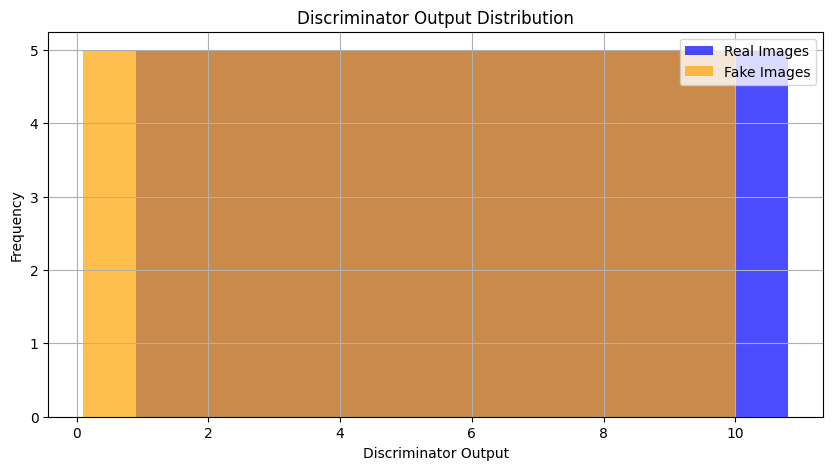

In [2]:
# Example of discriminator output histogram (real vs. fake)
def plot_discriminator_outputs(real_output, fake_output):
    plt.figure(figsize=(10, 5))
    plt.hist(real_output, bins=20, alpha=0.7, label="Real Images", color="blue")
    plt.hist(fake_output, bins=20, alpha=0.7, label="Fake Images", color="orange")
    plt.xlabel("Discriminator Output")
    plt.ylabel("Frequency")
    plt.title("Discriminator Output Distribution")
    plt.legend()
    plt.grid(True)
    plt.show()

# Simulate discriminator outputs
real_output = [0.9 + 0.1 * i for i in range(100)]  # Example values for real images
fake_output = [0.1 + 0.1 * i for i in range(100)]  # Example values for fake images

plot_discriminator_outputs(real_output, fake_output)
